In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.utils import make_grid


In [2]:
# Set mean and std (ImageNet-style normalization)
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# Transforms for train/val
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


In [3]:
# Updated dataset directory
data_dir = 'dataset'

# Load datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Classes:", class_names)


Classes: ['with_mask', 'without_mask']


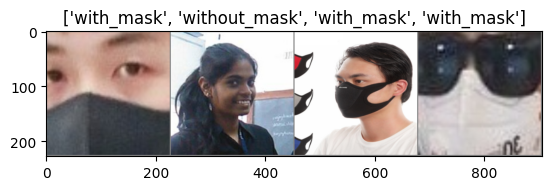

In [4]:
# Visual helper
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

# Show sample batch
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model




In [6]:
# Load pretrained ResNet18 and finetune all layers
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'Face_Mask_Detection_master.pth')


model_path = 'Face_Mask_Detection_master.pth'
torch.save(model.state_dict(), model_path)
print("✅ Model saved to:", os.path.abspath(model_path))


c:\Users\winds\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\winds\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


c:\Users\winds\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.4570 Acc: 0.8141
val Loss: 0.1743 Acc: 0.9399

Epoch 1/24
----------
train Loss: 0.3701 Acc: 0.8585
val Loss: 0.0554 Acc: 0.9858

Epoch 2/24
----------
train Loss: 0.3362 Acc: 0.8785
val Loss: 0.0361 Acc: 0.9905

Epoch 3/24
----------
train Loss: 0.3034 Acc: 0.8891
val Loss: 0.0332 Acc: 0.9921

Epoch 4/24
----------
train Loss: 0.1852 Acc: 0.9291
val Loss: 0.0319 Acc: 0.9937

Epoch 5/24
----------
train Loss: 0.1501 Acc: 0.9450
val Loss: 0.0327 Acc: 0.9984

Epoch 6/24
----------
train Loss: 0.1219 Acc: 0.9553
val Loss: 0.0599 Acc: 0.9953

Epoch 7/24
----------
train Loss: 0.0921 Acc: 0.9663
val Loss: 0.0511 Acc: 0.9953

Epoch 8/24
----------
train Loss: 0.0877 Acc: 0.9684
val Loss: 0.0301 Acc: 0.9984

Epoch 9/24
----------
train Loss: 0.0793 Acc: 0.9728
val Loss: 0.0395 Acc: 0.9921

Epoch 10/24
----------
train Loss: 0.0835 Acc: 0.9675
val Loss: 0.0499 Acc: 0.9905

Epoch 11/24
----------
train Loss: 0.0815 Acc: 0.9681
val Loss: 0.0363 Acc: 0.9984

Epoch 12/24
----------
t